In [1]:
# Import libraries for data handling, visualization, modeling, and time-series validation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


In [2]:
# Load electricity consumption datasets from multiple CSV files
df1 = pd.read_csv("KwhConsumptionBlower78_1.csv")
df2 = pd.read_csv("KwhConsumptionBlower78_2.csv")
df3 = pd.read_csv("KwhConsumptionBlower78_3.csv")

In [3]:
# Set the identifier column as index and standardize index naming
df1 = df1.set_index('Unnamed: 0')
df1.index.name = 'id'

df2 = df2.set_index('Unnamed: 0')
df2.index.name = 'id'

df3 = df3.set_index('Unnamed: 0')
df3.index.name = 'id'


In [4]:
# Combine datasets, create a unified datetime column, and sort chronologically
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

df["TxnDate"] = pd.to_datetime(df["TxnDate"])
df["datetime"] = pd.to_datetime(
    df["TxnDate"].astype(str) + " " + df["TxnTime"]
)

df = (
    df.sort_values("datetime")
      .reset_index(drop=True)
)


In [5]:
# Look at basic information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606 entries, 0 to 3605
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TxnDate      3606 non-null   datetime64[ns]
 1   TxnTime      3606 non-null   object        
 2   Consumption  3606 non-null   float64       
 3   datetime     3606 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 112.8+ KB


In [6]:
# Find total duplicated rows
df.duplicated().sum()

np.int64(24)

In [7]:
# Drop duplicated rows
df=df.drop_duplicates()

In [8]:
# Check if all rows increase monotically
print(df["datetime"].is_monotonic_increasing)

True


In [9]:
# Check first five samples
df.head()

,TxnDate,TxnTime,Consumption,datetime
0,2022-01-01,00:22:28,1.030,2022-01-01 00:22:28
1,2022-01-01,00:42:33,0.904,2022-01-01 00:42:33
2,2022-01-01,01:01:51,0.904,2022-01-01 01:01:51
3,2022-01-01,01:41:48,1.850,2022-01-01 01:41:48
4,2022-01-01,02:22:52,1.878,2022-01-01 02:22:52


In [10]:
# Check last five samples
df.tail()

,TxnDate,TxnTime,Consumption,datetime
3601,2022-02-28,22:25:43,1.152,2022-02-28 22:25:43
3602,2022-02-28,22:44:37,0.888,2022-02-28 22:44:37
3603,2022-02-28,23:07:15,1.064,2022-02-28 23:07:15
3604,2022-02-28,23:29:13,1.036,2022-02-28 23:29:13
3605,2022-02-28,23:50:27,1.000,2022-02-28 23:50:27


In [11]:
# Create time-based and cyclical features from datetime information
def feature_creation(df):       
    df['dow']   = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day']   = df['datetime'].dt.day
    df['hour']  = df['datetime'].dt.hour

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

    df['TimeOfDay'] = pd.cut(
        df['hour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        include_lowest=True
    )
    
    return df

# Apply feature creation
df=feature_creation(df)

# Map time-of-day categories to numeric values
TimeOfDay_mapping={'Night':1,'Morning':2,'Afternoon':3,'Evening':4}
df['TimeOfDay']=df['TimeOfDay'].map(TimeOfDay_mapping).astype(int)

# Set date as index
df = df.set_index('TxnDate')

In [12]:
df.head(5)

,TxnTime,Consumption,datetime,dow,month,day,hour,hour_sin,hour_cos,dow_sin,dow_cos,TimeOfDay
TxnDate,,,,,,,,,,,,
2022-01-01,00:22:28,1.030,2022-01-01 00:22:28,5,1,1,0,0.000000,1.000000,-0.974928,-0.222521,1
2022-01-01,00:42:33,0.904,2022-01-01 00:42:33,5,1,1,0,0.000000,1.000000,-0.974928,-0.222521,1
2022-01-01,01:01:51,0.904,2022-01-01 01:01:51,5,1,1,1,0.258819,0.965926,-0.974928,-0.222521,1
2022-01-01,01:41:48,1.850,2022-01-01 01:41:48,5,1,1,1,0.258819,0.965926,-0.974928,-0.222521,1
2022-01-01,02:22:52,1.878,2022-01-01 02:22:52,5,1,1,2,0.500000,0.866025,-0.974928,-0.222521,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3582 entries, 2022-01-01 to 2022-02-28
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TxnTime      3582 non-null   object        
 1   Consumption  3582 non-null   float64       
 2   datetime     3582 non-null   datetime64[ns]
 3   dow          3582 non-null   int32         
 4   month        3582 non-null   int32         
 5   day          3582 non-null   int32         
 6   hour         3582 non-null   int32         
 7   hour_sin     3582 non-null   float64       
 8   hour_cos     3582 non-null   float64       
 9   dow_sin      3582 non-null   float64       
 10  dow_cos      3582 non-null   float64       
 11  TimeOfDay    3582 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int32(4), int64(1), object(1)
memory usage: 307.8+ KB


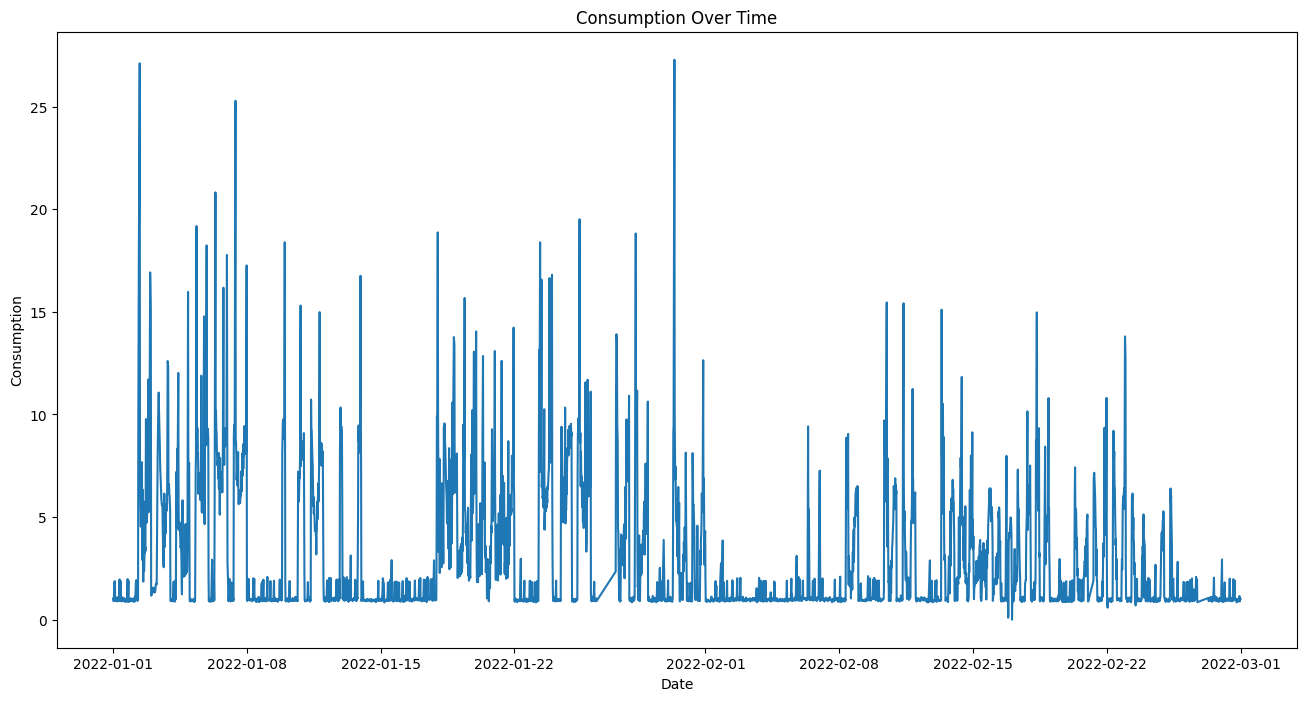

In [14]:
# Plot electricity consumption over time
plt.figure(figsize=(16,8))
plt.plot(df['datetime'], df['Consumption'])
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Over Time')
plt.show()

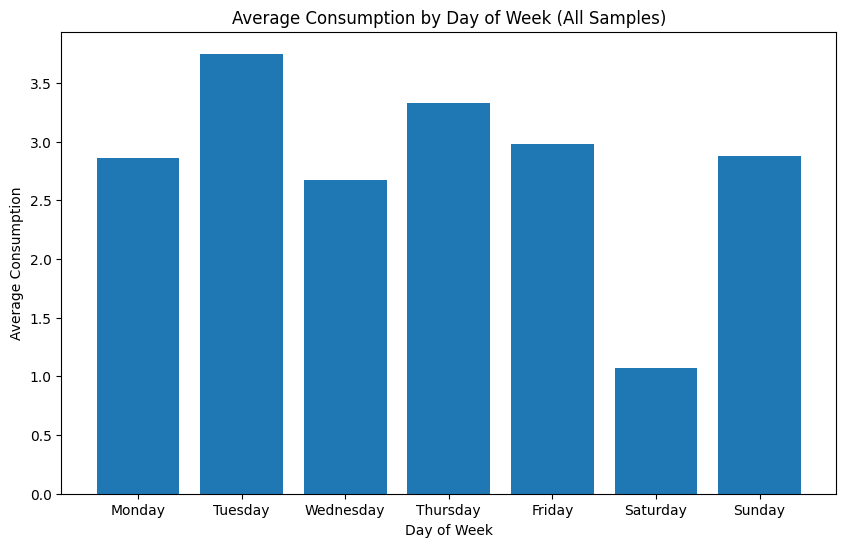

In [15]:
# Analyze and visualize average electricity consumption by day of week
dow_avg = (
    df.groupby('dow')['Consumption']
      .mean()
      .reset_index()
)

dow_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

dow_avg['day_name'] = dow_avg['dow'].map(dow_map)

plt.figure(figsize=(10, 6))
plt.bar(dow_avg['day_name'], dow_avg['Consumption'])
plt.xlabel('Day of Week')
plt.ylabel('Average Consumption')
plt.title('Average Consumption by Day of Week (All Samples)')
plt.show()


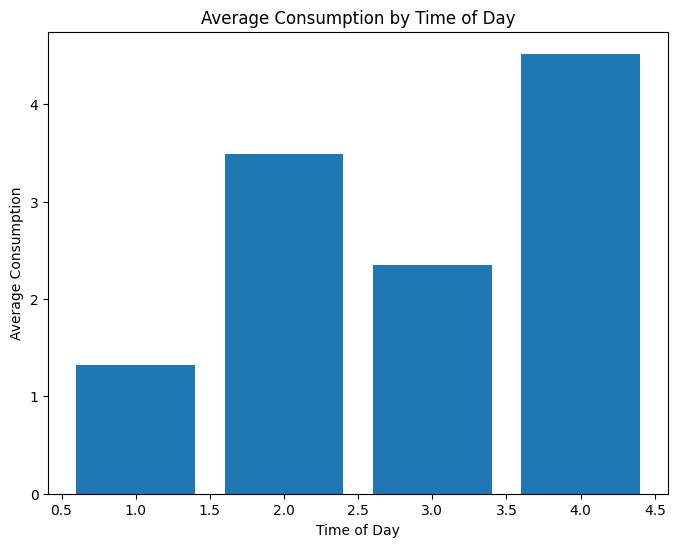

In [16]:
# Analyze and visualize average electricity consumption by time of day
tod_avg = (
    df.groupby('TimeOfDay')['Consumption']
      .mean()
      .reset_index()
)
plt.figure(figsize=(8, 6))
plt.bar(tod_avg['TimeOfDay'], tod_avg['Consumption'])
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption')
plt.title('Average Consumption by Time of Day')
plt.show()

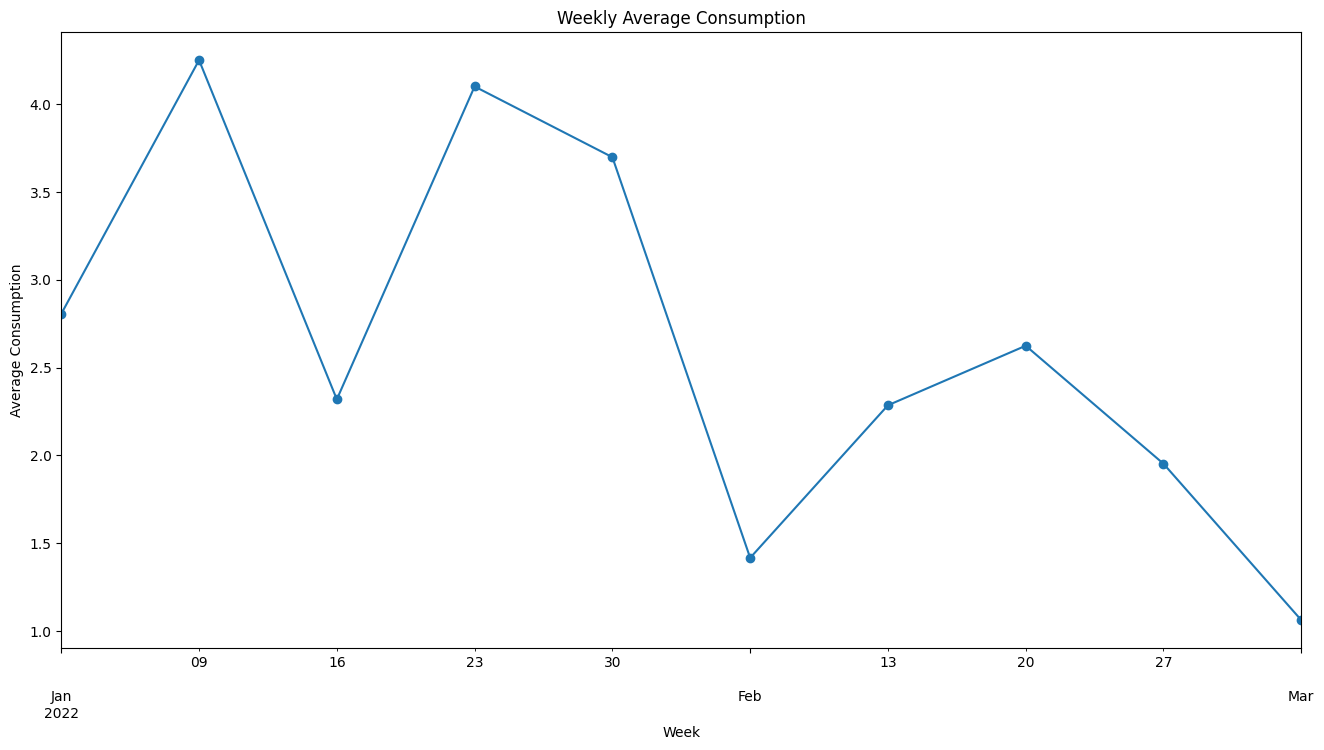

In [17]:
# Plot weekly average consumption
weekly_avg = df['Consumption'].resample('W').mean()
weekly_avg.plot(figsize=(16,8), marker='o')
plt.xlabel('Week')
plt.ylabel('Average Consumption')
plt.title('Weekly Average Consumption')
plt.show()


In [18]:
# Create time-series features including resampling, interpolation, lags, and rolling means
def create_timeseries_features(
    df,
    target_col='Consumption',
    freq='h',
    lags=(1, 6, 24)
):
    df = df.copy()

    df.index = pd.to_datetime(df.index) + pd.to_timedelta(df['hour'], unit='h')
    df = df.sort_index()

    df = df.resample(freq).mean()

    df[target_col] = df[target_col].interpolate(
        method='time',
        limit_direction='forward'
    )

    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)

        if lag > 1:
            df[f'roll_mean_{lag}'] = (
                df[target_col]
                .shift(1)
                .rolling(window=lag)
                .mean()
            )

    df = df.dropna()

    return df


In [19]:
# Remove unused columns and split the dataset into 80/20 train-test sets
df=df.drop(['TxnTime','datetime'],axis=1)
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df  = df.iloc[split_index:]

In [20]:
# Apply time-series features to both train and test separately to prevent data leakage from interpolation
train_df=create_timeseries_features(train_df)
test_df=create_timeseries_features(test_df)

In [21]:
train_df.head(24)

,Consumption,dow,month,day,hour,hour_sin,hour_cos,dow_sin,dow_cos,TimeOfDay,lag_1,lag_6,roll_mean_6,lag_24,roll_mean_24
2022-01-02 00:00:00,0.942667,6.0,1.0,2.0,0.0,0.000000e+00,1.000000e+00,-0.781831,0.62349,1.0,0.962667,1.425000,1.103000,0.967000,1.062264
2022-01-02 01:00:00,0.940000,6.0,1.0,2.0,1.0,2.588190e-01,9.659258e-01,-0.781831,0.62349,1.0,0.942667,1.417000,1.022611,1.377000,1.061250
2022-01-02 02:00:00,0.932000,6.0,1.0,2.0,2.0,5.000000e-01,8.660254e-01,-0.781831,0.62349,1.0,0.940000,0.905333,0.943111,1.485000,1.043042
2022-01-02 03:00:00,1.007000,6.0,1.0,2.0,3.0,7.071068e-01,7.071068e-01,-0.781831,0.62349,1.0,0.932000,0.934667,0.947556,0.929333,1.020000
2022-01-02 04:00:00,1.375000,6.0,1.0,2.0,4.0,8.660254e-01,5.000000e-01,-0.781831,0.62349,1.0,1.007000,0.973333,0.959611,0.922667,1.023236
2022-01-02 05:00:00,1.446000,6.0,1.0,2.0,5.0,9.659258e-01,2.588190e-01,-0.781831,0.62349,1.0,1.375000,0.962667,1.026556,0.976000,1.042083
2022-01-02 06:00:00,0.964000,6.0,1.0,2.0,6.0,1.000000e+00,6.123234e-17,-0.781831,0.62349,1.0,1.446000,0.942667,1.107111,0.936000,1.061667
2022-01-02 07:00:00,3.937333,6.0,1.0,2.0,7.0,9.659258e-01,-2.588190e-01,-0.781831,0.62349,2.0,0.964000,0.940000,1.110667,0.970000,1.062833
2022-01-02 08:00:00,17.884000,6.0,1.0,2.0,8.0,8.660254e-01,-5.000000e-01,-0.781831,0.62349,2.0,3.937333,0.932000,1.610222,1.276000,1.186472
2022-01-02 09:00:00,16.860000,6.0,1.0,2.0,9.0,7.071068e-01,-7.071068e-01,-0.781831,0.62349,2.0,17.884000,1.007000,4.435556,1.399000,1.878472


In [22]:

# -----------------------------
# Time-series cross validation
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)

X_train = train_df.drop(columns=['Consumption'])
y_train = train_df['Consumption']

X_test  = test_df.drop(columns=['Consumption'])
y_test  = test_df['Consumption']

# -----------------------------
# Model
# -----------------------------
model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=1
)

# -----------------------------
# Parameter grid
# -----------------------------
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# -----------------------------
# GridSearch
# -----------------------------
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# -----------------------------
# Fit on training data
# -----------------------------
grid_search.fit(X_train, y_train)

# -----------------------------
# Best model
# -----------------------------
best_model = grid_search.best_estimator_

print("Best RMSE (CV):", -grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

# -----------------------------
# Predict
# -----------------------------
y_pred = best_model.predict(X_test)

# Optional: clip if target cannot be negative
y_pred = np.clip(y_pred, a_min=0, a_max=None)

# -----------------------------
# Evaluate on test set
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best RMSE (CV): 1.7068094917710919
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Test RMSE: 1.1261567584363963


In [ ]:
# Train model on best parameters
model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    random_state=42,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.3f}")

Test RMSE: 1.143


In [24]:
# Look at features importance
importance = model.get_booster().get_score(importance_type='gain')

fi = (
    pd.DataFrame({
        'feature': importance.keys(),
        'gain': importance.values()
    })
    .sort_values('gain', ascending=False)
)

fi

,feature,gain
8,TimeOfDay,52.210068
9,lag_1,48.081131
3,hour,16.774742
1,month,13.761893
11,roll_mean_6,10.640309
4,hour_sin,7.654955
13,roll_mean_24,6.530540
5,hour_cos,5.581078
12,lag_24,4.977635
7,dow_cos,4.072954


Test RMSE: 1.143


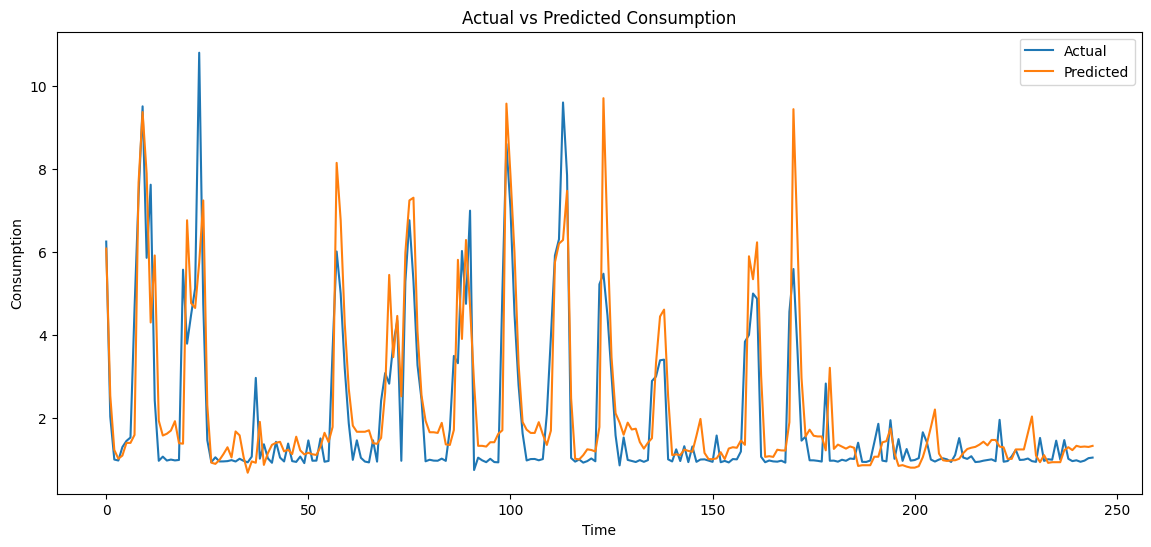

In [31]:
# Train model on all features
model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    random_state=42,
)

# Fit model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Consumption')
plt.legend()
plt.show()


Test RMSE: 1.158


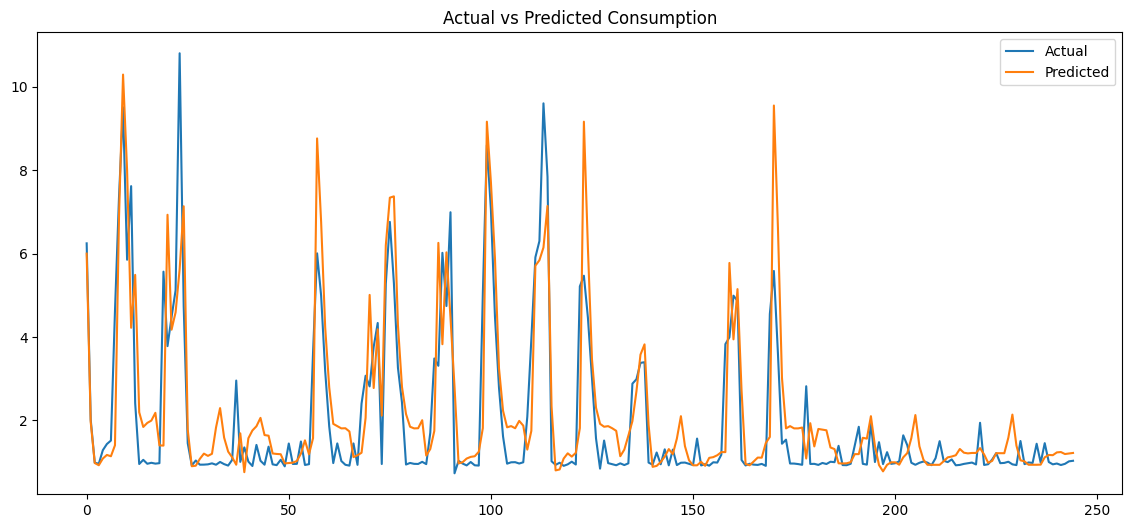

In [ ]:
# Select top features manually
selected_features = [
    'TimeOfDay',
    'lag_1',
    'hour',
    'month',
    'roll_mean_6',
    'hour_sin',
    'roll_mean_24'
]

# Prepare train / test matrices
X_train_k = X_train[selected_features]
X_test_k  = X_test[selected_features]

# Model with fixed best hyperparameters
model_k = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    random_state=42,
)

# Train
model_k.fit(X_train_k, y_train)

# Predict
y_pred = model_k.predict(X_test_k)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Consumption')
plt.show()
